###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D Time-Dependent Thermal Convection in the Earth Mantle

Finally, we can assemble our 2D time-dependent thermal convection code and compute the evolution of the temperature field for different initial conditions.

## Thermal Convection in the Earth Mantle

Before writing the convection code, lets shortly summarize the governing equations from the [introduction notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/01_2D_Mantle_Convection_intro.ipynb).

The full coupled set of scaled PDE's describe the coupling of incompressible 2D Navier Stokes flow with an advection-diffusion equation for temperature, and can be written in dimensionless form as,

$$ 
   \frac{1}{\mathrm{Pr}}\left[ \frac{\partial \omega}{\partial t} + \vec{v}\cdot\nabla\omega\right] = \nabla^2\omega + \mathrm{Ra}\frac{\partial T}{\partial x}
$$
$$
    \nabla^2 \psi = -\omega
$$
$$ 
    \frac{\partial T}{\partial t} + \vec{v}\cdot\nabla T = \nabla^2 T
$$

where

$$
    \vec{v}=(u,0,w) = \nabla\times\psi\hat{j}=(-\frac{\partial\psi}{\partial z}, 0,  \frac{\partial\psi}{\partial x})
$$ 

is the fluid velocity field (which in this form is exactly incompressible with $\nabla\cdot\vec{v}=0$).  $\psi$ is the "Streamfunction"  whose contours are tangent to the fluid trajectories at all times.  The vorticity,

$$
    \omega = \bf{\vec{\omega} \cdot \hat{j}} = (\nabla\times\vec{v}) \cdot \hat{j}
$$ 

measures the local rate of rotation of the fluid, and is driven by horizontal variations in temperature (actually density). $\hat{j}=(0,1,0)^T$ denotes the unit vector in y-direction.

Now, if we are dealing with mantle convection, the Prandtl number Pr becomes very large, actually it can be assumed to be inifinite. Therefore, the governing equations simplify to

\begin{equation}
\begin{split}
\nabla^2\omega &=  - \mathrm{Ra}\frac{\partial T}{\partial x}\\
\nabla^2 \psi &= -\omega\\
\frac{\partial T}{\partial t} &= \nabla^2 T - \vec{v}\cdot\nabla T
\end{split} 
\tag{1}
\end{equation}

The differential equations (1) consist of different subproblems. For a given temperature field $T$, we have to solve the coupled **Poisson equations**

\begin{equation}
\begin{split}
\nabla^2\omega &=  - \mathrm{Ra}\frac{\partial T}{\partial x}\\
\nabla^2 \psi &= -\omega
\end{split} 
\tag{2}
\end{equation}

in order to estimate the streamfunction $\psi$ and vorticity $\omega$. We already discussed the solution of a similar problem using the steepest descent method when trying to find [stationary solutions for the 2D thermal mantle convection problem](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/07_BVP_2D/05_BVP_2D_Thermal_Mantle_Convection.ipynb).

Therefore, the remaining problem is the 2D heat advection-diffusion problem from the conservation of energy equation 

\begin{equation}
\frac{\partial T}{\partial t} = \nabla^2 T - \vec{v}\cdot\nabla T \notag
\end{equation}

or by inserting the velocity vector $\vec{v}=(u,0,w) =(-\frac{\partial\psi}{\partial z}, 0,  \frac{\partial\psi}{\partial x})$ using the streamfunction

\begin{equation}
\frac{\partial T}{\partial t} = \nabla^2 T + \frac{\partial\psi}{\partial z} \frac{\partial T}{\partial x} - \frac{\partial\psi}{\partial x} \frac{\partial T}{\partial z} \tag{3}
\end{equation}

Using finite-differences, problem (3) can be further decomposed into two well known subproblems using **operator splitting**:

- The 2D linear advection problem:

\begin{equation}
\frac{\tilde{T}^{n+1}-T^{n}}{\Delta t} - \frac{\partial\psi}{\partial z} \frac{\partial T}{\partial x} + \frac{\partial\psi}{\partial x} \frac{\partial T}{\partial z} \tag{4}
\end{equation}

- The 2D heat conduction problem:

\begin{equation}
\frac{\partial \tilde{T}}{\partial t} = \nabla^2 \tilde{T} \tag{5}
\end{equation}

## How to solve the 2D time-dependent mantle convection problem 

In summary, we can solve the 2D mantle convection problem using the following approach. Starting from an initial condition $T_0, \psi_0, \omega_0$, we compute at each time step ...

1. For a given temperature field $T$, solve the Poisson equations (2) to estimate the streamfunction $\psi$ and vorticity $\omega$, as described in the [2D mantle convection BVP notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/07_BVP_2D/05_BVP_2D_Thermal_Mantle_Convection.ipynb)

2. Solve the 2D linear advection-diffusion problem eqs. (4) + (5)

We solved the 2D advection-diffusion problem described in step 2. by operator splitting and a combination of Marker-in-Cell and FTCS FD method in [this notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/03_2D_Linear_Advection_Diffusion.ipynb).

Time for some coding. As usual, we start by importing some basic Python libraries and set up the plotting environment.

In [2]:
# Import libraries
import numpy
from matplotlib import pyplot
%matplotlib inline

# import JIT from Numba
from numba import jit

# import Numpy Linear Algebra package 
from numpy import linalg as LA

# import SciPy Interpolation package
from scipy import interpolate

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

## 1. Solution of Poisson equations

We start with step 1: For a given temperature field $T$, solve the Poisson equations (2) to estimate the streamfunction $\psi$ and vorticity $\omega$, as described in the [2D mantle convection BVP notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/07_BVP_2D/05_BVP_2D_Thermal_Mantle_Convection.ipynb)

For the steepest descent method, we need a function to compute the action of the Laplace operator $\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial z^2}$ on an abritary field $u$. In `Alapl` the second derivatives are approximated by the three-point central operator:

In [4]:
# Compute Laplace operator applied to scalar field u
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def Alapl(u,nx,nz,dx2,dz2):
    
    A = numpy.zeros_like(u)
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,nz-1):                
                
            # Compute Laplace operator for scalar field u
            d2udx2 = (u[j, i+1] + u[j, i-1] - 2 * u[j, i]) / dx2
            d2udz2 = (u[j+1, i] + u[j-1, i] - 2 * u[j, i]) / dz2                                 
                            
            A[j, i] = d2udx2 + d2udz2
            
    return A         

Next, we have to define the RHS $b$ for the vorticity equation `bw` ...

In [5]:
# Compute b for vorticity equation
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def bw(T,nx,nz,dx,Ra):
    
    b = numpy.zeros_like(T)
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,nz-1):                
                
            # Compute b for vorticity equation
            dTdx = - Ra * (T[j,i] - T[j,i-1]) / dx                                 
                            
            b[j, i] = dTdx
            
    return b

Next, we can solve eqs. (2) using the iterative numerical method described above with the steepest descent method in the function `psi_w_bvp` in order to compute the streamfunction $\psi(x,z,t)$ and vorticity $\omega(x,z,t)$ fields.

In [6]:
# 2D thermal mantle convection code with JIT optimization
# -------------------------------------------------------
def psi_w_bvp(T, psi, w, niter, dx, dz, Ra, tol):
    
    """
    Computes and returns the stationary streamfunction and vorticity 
    fields based on the current temperature field for the 2D thermal 
    mantle convection problem using the steepest descent method.
    
    Parameters
    ----------
    T : numpy.ndarray
        The current temperature distribution as a 2D array of floats.
    psi : numpy.ndarray
        The current streamfunction as a 2D array of floats.    
    w : numpy.ndarray
        The current vorticity as a 2D array of floats.    
    niter : integer
        Maximum number of iterations using the steepest descent method.    
    dx : float
        Grid spacing in the x direction.
    dz : float
        Grid spacing in the z direction.
    Ra : float
        Rayleigh number.
    tol : float
        tolerance for abortion criterion.
    
    
    Returns
    -------
    psi : numpy.ndarray
        The streamfunction as a 2D array of floats.    
    w : numpy.ndarray
        The vorticity as a 2D array of floats.    
    """
    
    # Define some constants.
    dx2 = dx**2
    dz2 = dz**2
    
    r = numpy.zeros_like(psi)    # initial residuals
    Ar = numpy.zeros_like(psi)   # store mat-vec multiplication Ar
    
    # Estimate number of grid points in x- and y-direction
    nz, nx = T.shape
    
    # Iterate solution using the steepest descent method
    for n in range(niter):
        
        # 1. Compute new vorticity from previous temperature
        # --------------------------------------------------
        # store old T
        wk = w.copy()
        
        # Compute the residual.
        r = bw(T,nx,nz,dx,Ra) - Alapl(w,nx,nz,dx2,dz2)
        
        # Compute the Laplacian of the residual.
        Ar = Alapl(r,nx,nz,dx2,dz2)
        
        # Compute the step size.
        alpha = numpy.sum(r * r) / (numpy.sum(r * Ar))
        
        # Update the vorticity solution.
        w = wk + alpha * r
        
        # 2. Compute new streamfunction from new vorticity
        # ------------------------------------------------
        # store old T
        psik = psi.copy()
        
        # Compute the residual.
        r = - w - Alapl(psi,nx,nz,dx2,dz2)
        
        # Compute the Laplacian of the residual.
        Ar = Alapl(r,nx,nz,dx2,dz2)
        
        # Compute the step size.
        alpha = numpy.sum(r * r) / (numpy.sum(r * Ar))
        
        # Update the streamfunction solution.
        psi = psik + alpha * r
        
        # Compute relative L2 norm of streamfunction 
        Epsi = LA.norm(psi-psik, 2) / LA.norm(psi, 2)
        
        # check if tolerance criterion is satisfied
        if(Epsi <= tol):
            break
            
    return w, psi

##  2. Solution of 2D advection-diffusion problem

In step 2, we have to solve the advection-diffusion problem. The required Python code can be copied from the [previous notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/03_2D_Linear_Advection_Diffusion.ipynb). We write a function `update_diff_2D` to update the 2D diffusion equation (5) using the FTCS method.

In [7]:
# 2D Heat Diffusion Update
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def update_diff_2D(T, sigma_x, sigma_z, nx, nz):
    
    # store old temperature field
    Tn = T.copy()
        
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,nz-1):
                
            T[j, i] = (Tn[j, i] +
                        sigma_x * (Tn[j, i+1] - 2.0 * Tn[j, i] + Tn[j, i-1]) +
                        sigma_z * (Tn[j+1, i] - 2.0 * Tn[j, i] + Tn[j-1, i]))
            
    return T            

For the advection part, we have to compute the velocity field components from the streamfunction in order to use the Marker-in-Cell method. To do this, we write the small function `psi2vel`.

In [8]:
# Convert stream function to velocity field
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def psi2vel(Vx,Vz,psi,nx,nz,dx,dz):
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,nz-1):                
                
            # velocities Vx = -dpsi/dz, Vz = dpsi/dx
            Vx[j,i] = -(psi[j,i] - psi[j-1,i]) / dz
            Vz[j,i] = (psi[j,i] - psi[j,i-1]) / dx                       
                        
    return Vx, Vz

Now comes the most important part, we write the `mantle_convection` code, where the solution of the Poisson and advection-diffusion problems are assembled. During the solution of the mantle convection problem, we write the temperature field as `TIFF` images into the folder `image_out`. This requires to set the plotting routine to interactive mode, which is NOT possible in JupyterLab. Therefore, the code will NOT run in JupyterLab. The `TIFF` images can later be compiled to a time-lapse movie.

In [9]:
# 2D thermal mantle convection code with JIT optimization
# -------------------------------------------------------
def mantle_convection(T0, psi0, w0, niter, nt, dx, dz, Lx, Lz, dt, Ra, tol):
    
    """
    Computes and returns the temperature field, streamfunction and vorticity 
    fields for the 2D thermal mantle convection problem using the steepest 
    descent method for the Poisson problem and the Marker-in-Cell/FTCS FD method 
    to solve the advection-diffusion problem.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    psi0 : numpy.ndarray
        The initial streamfunction as a 2D array of floats.    
    w0 : numpy.ndarray
        The initial vorticity as a 2D array of floats.    
    niter : integer
        Maximum number of iterations using the steepest descent method.    
    dx : float
        Grid spacing in the x direction.
    dz : float
        Grid spacing in the z direction.
    Ra : float
        Rayleigh number.
    Lx : float
        Extension of the model in x-direction.
    Lz : float
        Extension of the model in z-direction.    
    dt : float
        Time step. 
    Ra : float
        Rayleigh number.
    tol : float
        tolerance for abortion criterion.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    psi : numpy.ndarray
        The streamfunction as a 2D array of floats.    
    w : numpy.ndarray
        The vorticity as a 2D array of floats.    
    """    
    
    # Copy fields
    T = T0.copy()
    psi = psi0.copy()
    w = w0.copy()
    
    # Initialize velocity fields
    Vx = numpy.zeros_like(psi)
    Vz = numpy.zeros_like(psi)
    
    # Estimate number of grid points in x- and y-direction
    nz, nx = T.shape
    
    # Define the locations along a gridline.
    x = numpy.linspace(0, Lx, num=nx)
    z = numpy.linspace(0, Lz, num=nz)

    # Define the initial temperature distribution as Gaussian function
    X, Z = numpy.meshgrid(x,z) # coordinates X,Z required to define T0
    
    # Define some constants.
    dx2 = dx**2
    dz2 = dz**2

    sigma_x = dt / dx2
    sigma_z = dt / dz2
    
    # Define number of markers and initial marker positions
    nx_mark = 4 * nx  # number of markers in x-direction
    nz_mark = 4 * nz  # number of markers in z-direction
    
    # Plot the initial temperature distribution and streamlines
    fig = pyplot.figure(figsize=(13., 5.))
    pyplot.tight_layout()
    extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
    cmap = 'jet'
    im = pyplot.imshow(numpy.flipud(T), extent=extent, interpolation='spline36', cmap=cmap)

    pyplot.xlabel('x [ ]')
    pyplot.ylabel('z [ ]')
    cbar = pyplot.colorbar(im)
    pyplot.gca().invert_yaxis()
    cbar.set_label('Temperature [ ]')
    
    # activate interactive plot
    pyplot.ion()    
    pyplot.show(block=False)  
    
    # write temperature field snapshots every nsnap time steps to image file
    nsnap = 1
    
    # Loop over timesteps
    for n in range(nt):
        
        # 1. Compute phi and w based on current temperature field
        # -------------------------------------------------------
        w, psi = psi_w_bvp(T, psi, w, niter, dx, dz, Ra, tol)
        
        # 2. Compute T from Advection-Diffusion equation using Marker-in-Cell & FTCS method
        # ---------------------------------------------------------------------------------
        
        # Compute velocity fields from stream function
        Vx, Vz = psi2vel(Vx,Vz,psi,nx,nz,dx,dz)
        
        # initial marker positions
        x_mark = numpy.linspace(0, Lx, num=nx_mark)
        z_mark = numpy.linspace(0, Lz, num=nz_mark)
        X_mark, Z_mark = numpy.meshgrid(x_mark,z_mark)
        
        # Interpolate velocities from grid to marker position at timestep n        
        f = interpolate.interp2d(x, z, Vx, kind='linear')
        vx_mark_n = f(x_mark, z_mark)
        
        f = interpolate.interp2d(x, z, Vz, kind='linear')
        vz_mark_n = f(x_mark, z_mark)
        
        # Interpolate temperature from grid to marker position at timestep n
        f = interpolate.interp2d(x, z, T, kind='cubic')
        T_mark = f(x_mark, z_mark)
        
        # Save current marker positions
        X0 = X_mark
        Z0 = Z_mark
        
        # Update marker position
        X_mark = X_mark + vx_mark_n * dt
        Z_mark = Z_mark + vz_mark_n * dt
        
        # Interpolate velocities from grid to marker position at timestep n+1 
        vx_mark_n1 = interpolate.griddata((X.flatten(), Z.flatten()), Vx.flatten(), (X_mark, Z_mark), method='linear')
        vz_mark_n1 = interpolate.griddata((X.flatten(), Z.flatten()), Vz.flatten(), (X_mark, Z_mark), method='linear')
        
        # Replace Nan values 
        mask = numpy.where(numpy.isnan(vx_mark_n1))
        vx_mark_n1[mask] = 0
        
        mask = numpy.where(numpy.isnan(vz_mark_n1))
        vz_mark_n1[mask] = 0
        
        # Update marker position with midpoint velocity
        X_mark = X0 + dt * (vx_mark_n + vx_mark_n1) / 2.
        Z_mark = Z0 + dt * (vz_mark_n + vz_mark_n1) / 2.

        # Interpolate temperature field from marker to grid positions
        T = interpolate.griddata((X_mark.flatten(), Z_mark.flatten()), T_mark.flatten(), (X, Z), method='cubic')
        
        # Replace Nan-values by old temperature field 
        mask = numpy.where(numpy.isnan(T))
        T[mask] = T0[mask]
        
        # Update diffusion equation
        T = update_diff_2D(T, sigma_x, sigma_z, nx, nz)
        
        # Apply Neumann boundary condition (dTdx=0) at left and right boundary
        T[:,0] = T[:,1]
        T[:,-1] = T[:,-2]
        
        # update temperature/velocity fields and time
        if (n % nsnap) == 0:        
            im.set_data(numpy.flipud(T))
            fig.canvas.draw()
            name_snap = "image_out/Conv_2D_" + "%0.*f" %(0,numpy.fix(n+1000)) + ".tiff"
            pyplot.savefig(name_snap, format='tiff', bbox_inches='tight', dpi=125)
                    
    return T, w, psi

## First 2D Mantle Convection Modelling Run

After writing the `mantle_convection` code and all the required functions attached to it, we can define and run our first 2D mantle convection model.

Let's assume that the dimensionless width of the earth mantle is $ L_x = 2$ in x-direction and it has a thickness of $L_z = 1$. The model is discretized with $nx=204$ gridpoints in x-direction and $ny=102$ gridpoints in z-direction. Regarding the thermal properties, assume a dimensionless temperature of $\text{Tbot} = 1$ at the bottom of the mantle and a temperature $\text{Tsurf} = 0$ at the top boundary. 

Furthermore, we have to make an initial guess for the temperature field $T_0$ in the mantle. Let 's assume it consists of two parts:

$$
T_0 = T_{lin} - T_{2D}
$$

a 1D linear temperature gradient

$$
T_{lin} = \frac{(Tbot-Tsurf)}{Lz} * Z + Tsurf
$$

and a 2D temperature variation in x-direction:

$$
T_{2D} = p\; cos\biggl(\frac{2 k \pi x}{L_x}\biggr)
$$

Does the 2D temperature distribution look familiar? You have already encountered it, when dealing with the [Lorenz equations](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/03_Lorenz_equations/01_LorenzEquations_intro.ipynb). It was one of the modes of the highly truncated Fourier series of the temperature field.

Regarding the parameters $p$ and $k$, lets start with $p=0.01$ and $k=1$ from the [manual of the mantle convection code ASPECT](http://www.math.clemson.edu/~heister/manual.pdf). For the initial streamfunction and vorticity, we assume $\psi_0(x,z)=\omega_0(x,z)=0$. Furthermore, Dirichlet boundary conditions for $psi$ and $\omega$ are set to 

\begin{equation}
\begin{split}
\psi(0,z) &= \psi(L_x,z) = \psi(x,0) = \psi(x,L_z) = 0\\  
\omega(0,z) &= \omega(L_x,z) = \omega(x,0) = \omega(x,L_z) = 0\\  
\end{split} \notag
\end{equation}

For the temperature distribution $T$ Dirichlet boundary conditions are assumed on the top and bottom boundary:
\begin{equation}
\begin{split}
T(x,0) &= \text{Tsurf} = 0\\
T(x,L_z) &= \text{Tbot} = 1\\
\end{split}\notag
\end{equation}

Neumann boundary conditions are set at the left and right boundary

\begin{equation}
\begin{split}
&\frac{\partial T}{\partial x}(0,z) = 0\\
&\frac{\partial T}{\partial x}(L_x,z) = 0\\
\end{split}\notag
\end{equation}

In [10]:
# Definition of modelling parameters
# ----------------------------------
Lx = 2.0     # width of the mantle in the x direction []
Lz = 1.0     # thickness of the mantle in the z direction []
nx = 204     # number of points in the x direction
nz = 102     # number of points in the z direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dz = Lz / (nz - 1)  # grid spacing in the z direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
z = numpy.linspace(0.0, Lz, num=nz)

# Define initial temperature guess
Tbot = 1.     # temperature at the bottom boundary []
Tsurf = 0.    # temperature at the top boundary []

X, Z = numpy.meshgrid(x,z) # coordinates X,Z required to define T0

# Assume 1D linear increasing temperature profile with 2D perturbation
Tlin = (Tbot-Tsurf)/Lz * Z + Tsurf # linear temperature increase with depth

# 2D temperature perturbation in x-direction with parameters from 
# the Spiegelmann script
p = 0.01
k = 1.  # boring initial condition
#k = 1.42   # more interesting initial condition
T2D = p * numpy.cos(k * 2. * numpy.pi * X / Lx)

# Initial temperature distribution
T0 = Tlin - T2D 

# Apply Dirichlet boundary condition for the temperature 
# at the top and bottom boundary
T0[0,:] = Tsurf
T0[-1,:] = Tbot

# Define initial streamfunction guess
psi0 = numpy.zeros((nz,nx))

# Define initial vorticity guess
w0 = numpy.zeros((nz,nx))

# Define maximum number of iterations niter 
# and tolerance tol for iterative Poisson solver
niter = 10000
tol = 1e-4

# Compute time step dt using the CFL-criterion
sigma = 0.25
dt = sigma * min(dx, dz)**2  # time-step size

After setting almost all modelling parmeters in the cell above, it might be a good idea to compute the **Rayleigh number $Ra$** of the earth mantle:

$$
Ra = \frac{\rho g \alpha \Delta T d^3}{\eta \kappa}
$$

In [11]:
rho = 4000.   # density of the earth mantle [kg/m^3]
g = 9.81      # gravity accelaration [m/s^2]
alpha = 3e-5  # thermal expansion coefficient [K^-1]
DeltaT = 3000 # temperature difference between earth surface and core-mantel boundary [K]
d = 2900. * 1000 # thickness of the earth mantle [m]
eta = 1e22    # shear viscosity [Pa s]
kappa = 1e-6  # thermal diffusivity [m^2/s]

# Rayleigh number of earth mantle
Ra = rho * g * alpha * DeltaT * d**3 /(eta * kappa)

print("Ra = ", Ra)

Ra =  8613219.24


A Rayleigh number `Ra=8.6e6` is well above the critical Rayleigh number. It would require an even finer spatial model discretization than defined above. Therefore, we will use a Rayleigh number of `Ra=1e6`, which will already show most of the features also present when modelling with the higher Rayleigh number.

After setting all modelling parameters, we can run the `mantle_convection` modelling code to compute the numerical solution after `nt=293` time steps.

##### Warning

When executing the mantle convection code cell below, expect a computation time of roughly an hour. On my desktop gaming PC (Intel Core i7-6700K CPU @ 4 GHz, 16 GB Ram) the runtime for `nt=293` was about 37 mins. 

<IPython.core.display.Javascript object>


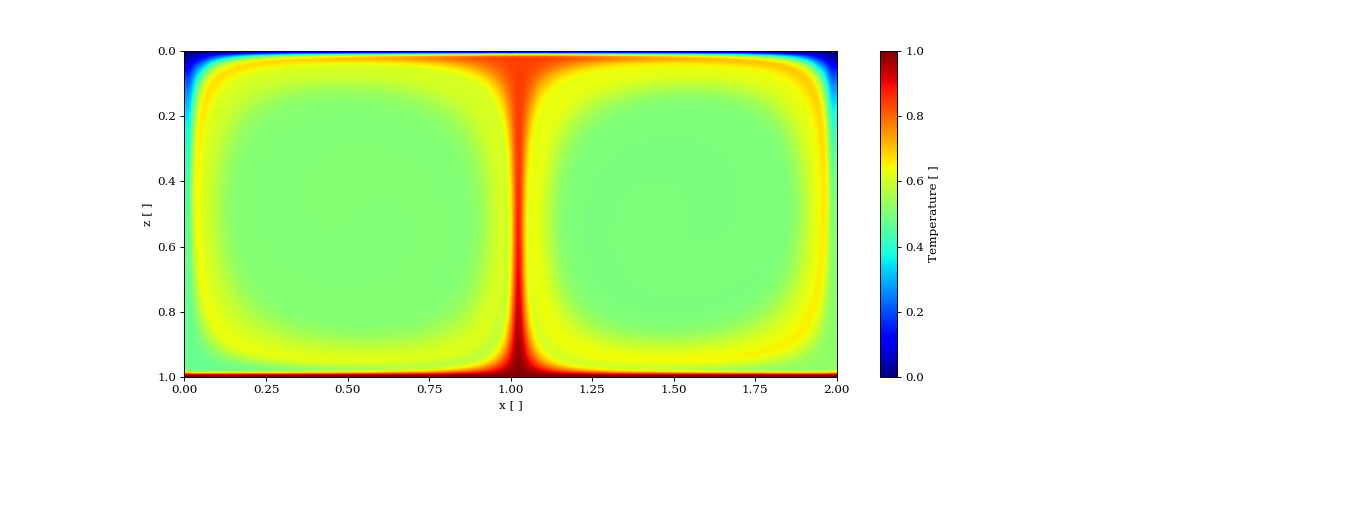

In [12]:
%matplotlib notebook
# Define Rayleigh number []
Ra = 1e6

# number of time steps to compute
nt = 293

# Compute temperature, streamfunction and temperature distribution
T, w, psi = mantle_convection(T0, psi0, w0, niter, nt, dx, dz, Lx, Lz, dt, Ra, tol)

After assembling the snapshots from the `image_out/` directory, we get the following movie ...

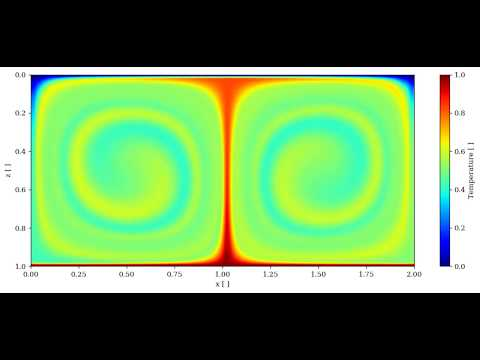

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo('uicDT4nIq-Q')

Notice, how fast a stable convection pattern is formed from the symmetric initial temperature distribution, despite the large Rayleigh number. In the convection cell on the left side we have a counter-clockwise convection current, while a clockwise convection occurs on the right side. The advection pattern in these cells looks quite similar to the Gaussian temperature anomaly in the velocity field used in the Lorenz approximation, as modelled in [this notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/02_2D_Linear_Advection.ipynb). Beside the advection, the diffusion part also "averages" the temperature in the convection cells. After `nt=239` timesteps an average temperature of `T=0.5` is reached.

The temperature only changes in thin boundary layers on the top and bottom of the mantle model. From the heated bottom boundary hot material rises to the surface in a very thin plume at the center of the model. Cold material sinks from the surface to the core-mantle boundary near the left and right model boundary.

What happens, if we impose different initial conditions, by setting `k=1.42` in order to break the symmetry of the 2D initial temperature field? The animation below is based on this initial condition and covers `nt=1717` time steps with a total runtime of 3h 36min on my desktop PC. 

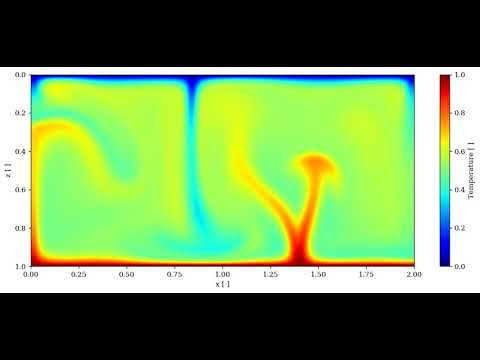

In [14]:
YouTubeVideo('9gqsNUD0Mdw')

Compared to the first modelling run with the symmetric initial condition, no stable convection pattern can be established. Instead a time-dependent, complex convection pattern occurs, where hot plumes are rising from the lower boundary layer and cold plumes are descending from the top boundary layer. Hot and cold plumes are interacting with each other. It is a quite complex solution and fascinating to watch.

## What we learned:

* How to write a complex 2D thermal convection by splitting the governing equations into subproblems, solve and verify them separately and finally assemble them again in order to solve the complex problem

* Even at a Rayleigh number of Ra = 1e6, we can get a quite stable convection pattern, assuming a symmetric 2D temperature distribution as initial condition

* On the other hand, assuming a non-symmetric 2D temperature distribution leads to complex time-dependent convection patterns.